# Extract annotation information from RBC-GEM
## Setup
### Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from rbc_gem_utils import (
    COBRA_CONFIGURATION,
    ROOT_PATH,
    MODEL_PATH,
    INTERIM_PATH,
    read_rbc_model,
    show_versions,
    get_annotation_df,
    compare_tables,
    visualize_comparison,
    split_string,
)

from rbc_gem_utils.annotation import set_sbo_default_annotations

# Display versions of last time notebook ran and worked
show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

### Define configuration
#### COBRA Configuration

In [2]:
COBRA_CONFIGURATION

Attribute,Description,Value
solver,Mathematical optimization solver,glpk
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-1000.0
upper_bound,Default reaction upper bound,1000.0
processes,Number of parallel processes,15
cache_directory,Path for the model cache,/Users/zhaiman/Library/Caches/cobrapy
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


## Load RBC-GEM model

In [3]:
model = read_rbc_model(filetype="xml")
model.reactions.sort()
model.genes.sort()
model.metabolites.sort()
model

Name,RBC_GEM
Memory address,143f2e010
Number of metabolites,1967
Number of reactions,2788
Number of genes,653
Number of groups,74
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


## Extract annotations from model

In [4]:
compare = True
display_nunique = True
overwrite = True
reset_all = False  # Using this option resets the model datasheets except default SBO terms. Use this to rewrite the annotations based on the current model annotations (typically stored in 'xml' model)
reset_sbo = False  # Using this option resets the model SBO terms to default values before exporting the sheet. Also occurs when reset_all is True, regardless of this value..

In [5]:
if reset_all:
    for attr in ["reactions", "metabolites", "genes"]:
        for x in getattr(model, attr):
            x.annotation.clear()

if reset_sbo or reset_all:
    # Reset SBO annotations
    set_sbo_default_annotations(
        model, ["reactions", "metabolites", "genes"], verbose=False
    )

### Reactions

In [6]:
annotation_type = "reactions"
all_annotation_keys = set()
for annotation in getattr(model, annotation_type).list_attr("annotation"):
    all_annotation_keys.update(list(annotation.keys()))
# Get annotation df is agnostic to object type, swap ID column with the `annotation_type`
df_annotations = get_annotation_df(
    getattr(model, annotation_type), sorted(list(all_annotation_keys))
).rename({"id": annotation_type}, axis=1)
df_annotations

,reactions,bigg.reaction,biocyc,ec-code,kegg.reaction,metanetx.reaction,metatlas,reactome,references,rhea,sabiork.reaction,sbo,seed.reaction,spontaneous,tcdb,vmhreaction
0,13DAMPPOX,13DAMPPOX,NaN,1.4.3.6;1.4.3.21;1.4.3.22,NaN,MNXR94687,MAR07992,NaN,pubmed:23330127,NaN,NaN,SBO:0000176,NaN,0,NaN,13DAMPPOX
1,15KPGE1Ry,15KPGE1Ry,NaN,NaN,NaN,NaN,NaN,NaN,pubmed:236730;pubmed:24657656;pubmed:6597453;p...,NaN,NaN,SBO:0000176,NaN,0,NaN,NaN
2,15KPGE2Ry,15KPGE2Ry,NaN,NaN,NaN,NaN,NaN,NaN,pubmed:236730;pubmed:24657656;pubmed:6597453;p...,NaN,NaN,SBO:0000176,NaN,0,NaN,NaN
3,15KPGE3Ry,15KPGE3Ry,NaN,NaN,NaN,NaN,NaN,NaN,pubmed:236730;pubmed:24657656;pubmed:6597453;p...,NaN,NaN,SBO:0000176,NaN,0,NaN,NaN
4,15KPGF1Ry,15KPGF1Ry,NaN,NaN,NaN,NaN,NaN,NaN,pubmed:236730;pubmed:24657656;pubmed:6597453;p...,NaN,NaN,SBO:0000176,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2783,XYLt,XYLt,NaN,NaN,NaN,MNXR105270,MAR08867,NaN,pubmed:23506862;pubmed:4487965;pubmed:5084118,NaN,NaN,SBO:0000185,NaN,0,NaN,XYLt
2784,YYDPP,YYDPP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBO:0000176,NaN,0,NaN,NaN
2785,YYYTPAP,YYYTPAP,NaN,NaN,NaN,NaN,NaN,NaN,pubmed:6058286;pubmed:7002549,NaN,NaN,SBO:0000176,NaN,0,NaN,NaN
2786,ZN2Htex2,ZN2Htex2,NaN,NaN,NaN,NaN,NaN,NaN,pubmed:11817695;pubmed:18936201;pubmed:33996761,NaN,NaN,SBO:0000185,NaN,0,NaN,NaN


reactions: 2788
bigg.reaction: 3509
biocyc: 188
ec-code: 383
kegg.reaction: 508
metanetx.reaction: 1008
metatlas: 1408
reactome: 243
references: 885
rhea: 496
sabiork.reaction: 149
sbo: 3
seed.reaction: 288
spontaneous: 2
tcdb: 28
vmhreaction: 1432


,reactions,bigg.reaction,biocyc,ec-code,kegg.reaction,metanetx.reaction,metatlas,reactome,references,rhea,sabiork.reaction,sbo,seed.reaction,spontaneous,tcdb,vmhreaction
0,13DAMPPOX,13DAMPPOX,NaN,1.4.3.6;1.4.3.21;1.4.3.22,NaN,MNXR94687,MAR07992,NaN,pubmed:23330127,NaN,NaN,SBO:0000176,NaN,0,NaN,13DAMPPOX
1,15KPGE1Ry,15KPGE1Ry,NaN,NaN,NaN,NaN,NaN,NaN,pubmed:236730;pubmed:24657656;pubmed:6597453;p...,NaN,NaN,SBO:0000176,NaN,0,NaN,NaN
2,15KPGE2Ry,15KPGE2Ry,NaN,NaN,NaN,NaN,NaN,NaN,pubmed:236730;pubmed:24657656;pubmed:6597453;p...,NaN,NaN,SBO:0000176,NaN,0,NaN,NaN
3,15KPGE3Ry,15KPGE3Ry,NaN,NaN,NaN,NaN,NaN,NaN,pubmed:236730;pubmed:24657656;pubmed:6597453;p...,NaN,NaN,SBO:0000176,NaN,0,NaN,NaN
4,15KPGF1Ry,15KPGF1Ry,NaN,NaN,NaN,NaN,NaN,NaN,pubmed:236730;pubmed:24657656;pubmed:6597453;p...,NaN,NaN,SBO:0000176,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2783,XYLt,XYLt,NaN,NaN,NaN,MNXR105270,MAR08867,NaN,pubmed:23506862;pubmed:4487965;pubmed:5084118,NaN,NaN,SBO:0000185,NaN,0,NaN,XYLt
2784,YYDPP,YYDPP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBO:0000176,NaN,0,NaN,NaN
2785,YYYTPAP,YYYTPAP,NaN,NaN,NaN,NaN,NaN,NaN,pubmed:6058286;pubmed:7002549,NaN,NaN,SBO:0000176,NaN,0,NaN,NaN
2786,ZN2Htex2,ZN2Htex2,NaN,NaN,NaN,NaN,NaN,NaN,pubmed:11817695;pubmed:18936201;pubmed:33996761,NaN,NaN,SBO:0000185,NaN,0,NaN,NaN


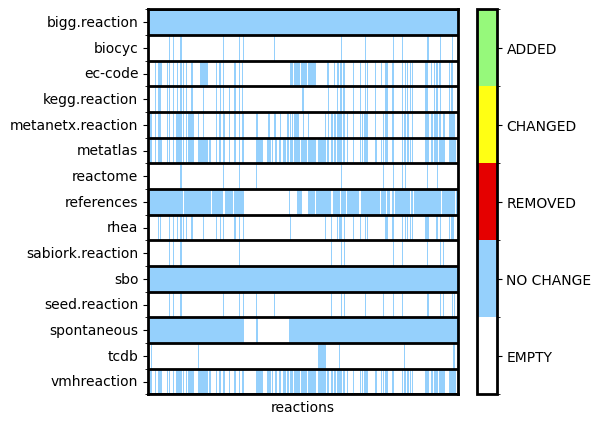

In [7]:
annotation_type = "reactions"
all_annotation_keys = set()
for annotation in getattr(model, annotation_type).list_attr("annotation"):
    all_annotation_keys.update(list(annotation.keys()))
# Get annotation df is agnostic to object type, swap ID column with the `annotation_type`
df_annotations = get_annotation_df(
    getattr(model, annotation_type), sorted(list(all_annotation_keys))
).rename({"id": annotation_type}, axis=1)

if compare:
    try:
        df_previous = pd.read_csv(
            f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv",
            sep="\t",
            index_col=0,
            dtype=str,
        )
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=[annotation_type], dtype=str)

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    df_comparision = compare_tables(
        df_previous.set_index(annotation_type),
        df_annotations.set_index(annotation_type),
    )
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = (
            df_annotations[col]
            .apply(lambda x: split_string(x))
            .explode(col)
            .drop_duplicates()
        )
        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_annotations.to_csv(f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv", sep="\t")
else:
    df_annotations.to_csv(f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}.tsv", sep="\t")
df_annotations

### Metabolites

metabolites: 1967
bigg.metabolite: 1967
biocyc: 212
chebi: 709
envipath: 72
hmdb: 501
inchikey: 184
kegg.compound: 765
kegg.drug: 64
kegg.glycan: 6
lipidmaps: 227
metanetx.chemical: 1171
metatlas: 1448
pubchem.compound: 676
reactome: 455
sabiork.compound: 218
sbo: 1
seed.compound: 224
slm: 7
vmhmetabolite: 1142


,metabolites,bigg.metabolite,biocyc,chebi,envipath,hmdb,inchikey,kegg.compound,kegg.drug,kegg.glycan,lipidmaps,metanetx.chemical,metatlas,pubchem.compound,reactome,sabiork.compound,sbo,seed.compound,slm,vmhmetabolite
0,10fthf_c,10fthf_c,NaN,CHEBI:15637,NaN,NaN,NaN,C00234,NaN,NaN,NaN,MNXM237,MAM00266c,122347,NaN,NaN,SBO:0000247,NaN,NaN,10fthf
1,12ppd__R_c,12ppd__R_c,NaN,CHEBI:16997,NaN,HMDB0001881,NaN,C00583,NaN,NaN,NaN,MNXM1118;MNXM1255;MNXM90191,MAM02771c,1030,NaN,NaN,SBO:0000247,NaN,NaN,12ppd_R
2,12ppd__S_c,12ppd__S_c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBO:0000247,NaN,NaN,NaN
3,13dampp_c,13dampp_c,NaN,CHEBI:15725,NaN,HMDB0000002,NaN,C00986,NaN,NaN,NaN,MNXM146468;MNXM350,MAM00248c,428,NaN,NaN,SBO:0000247,NaN,NaN,13dampp
4,13dpg_c,13dpg_c,META:DPG,CHEBI:16001,NaN,HMDB62758,LJQLQCAXBUHEAZ-UWTATZPHSA-J,C00236,NaN,NaN,NaN,MNXM261,MAM00247c,439191,29800,21215,SBO:0000247,cpd00203,NaN,13dpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1962,zn2_c,zn2_c,NaN,CHEBI:29105,NaN,HMDB0015532,NaN,C00038,NaN,NaN,NaN,MNXM149,MAM03157c,32051,NaN,NaN,SBO:0000247,NaN,NaN,zn2
1963,zn2_e,zn2_e,NaN,CHEBI:29105,NaN,HMDB0015532,NaN,C00038,NaN,NaN,NaN,MNXM149,MAM03157e,32051,NaN,NaN,SBO:0000247,NaN,NaN,zn2
1964,ztp_c,ztp_c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBO:0000247,NaN,NaN,NaN
1965,zymst_c,zymst_c,NaN,CHEBI:18252,NaN,NaN,NaN,C05437,NaN,NaN,LMST01010066,MNXM574,MAM03158c,92746,NaN,NaN,SBO:0000247,NaN,NaN,zymst


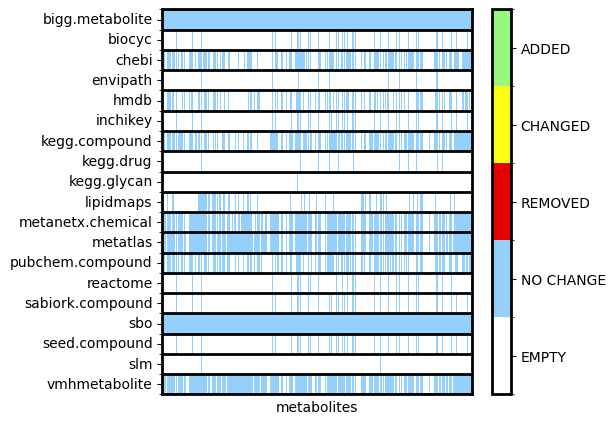

In [8]:
annotation_type = "metabolites"
all_annotation_keys = set()
for annotation in getattr(model, annotation_type).list_attr("annotation"):
    all_annotation_keys.update(list(annotation.keys()))
# Get annotation df is agnostic to object type, swap ID column with the `annotation_type`
df_annotations = get_annotation_df(
    getattr(model, annotation_type), sorted(list(all_annotation_keys))
).rename({"id": annotation_type}, axis=1)

if compare:
    try:
        df_previous = pd.read_csv(
            f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv",
            sep="\t",
            index_col=0,
            dtype=str,
        )
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=[annotation_type], dtype=str)

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    df_comparision = compare_tables(
        df_previous.set_index(annotation_type),
        df_annotations.set_index(annotation_type),
    )
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = (
            df_annotations[col]
            .apply(lambda x: split_string(x))
            .explode(col)
            .drop_duplicates()
        )
        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_annotations.to_csv(f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv", sep="\t")
else:
    df_annotations.to_csv(f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}.tsv", sep="\t")
df_annotations

### Genes

genes: 653
bgee.gene: 652
biocyc: 246
biogrid: 655
bmrb: 67
brenda: 374
cazy: 18
ccds: 1134
cdd: 523
chembl.target: 436
complexportal: 149
dbsnp: 4129
dip: 182
disprot: 33
drugbank: 2065
drugcentral: 640
ec-code: 486
eggnog: 498
ena.embl: 6964
ensembl: 468
genecards: 654
genetree: 595
genewiki: 490
go: 5230
hamap: 86
hgnc: 654
hgnc.symbol: 654
hogenom: 476
hpa: 652
hprd: 90
ideal: 20
interpro: 1648
iuphar.receptor: 149
kegg.genes: 634
merops: 33
mgi: 685
mim: 1133
ncbigene: 657
ncbigi: 108
nextprot: 653
oma.grp: 621
orphanet: 455
orthodb: 468
panther.family: 1108
pdb: 9365
peroxibase: 11
pfam: 615
pharmgkb.gene: 649
pirsf: 132
prints: 180
prosite: 357
proteomicsdb.protein: 1397
reactome: 893
references: 595
refseq: 1967
sasbdb: 29
sbo: 1
smart: 147
smpdb: 605
smr: 637
supfam: 282
taxonomy: 1
tcdb: 129
treefam: 500
uniparc: 653
uniprot: 653
uniprot.chain: 686
uniprot.isoform: 170


,genes,bgee.gene,biocyc,biogrid,bmrb,brenda,cazy,ccds,cdd,chembl.target,...,smpdb,smr,supfam,taxonomy,tcdb,treefam,uniparc,uniprot,uniprot.chain,uniprot.isoform
0,A4GALT,ENSG00000128274,MetaCyc:HS05171-MONOMER,119825,NaN,2.4.1.228,GT32,CCDS14041.1,NaN,NaN,...,NaN,NaN,SSF53448,9606,NaN,TF324053,UPI000003FF92,Q9NPC4,PRO_0000080578,NaN
1,AARS1,ENSG00000090861,NaN,106534,NaN,NaN,NaN,CCDS32474.1,cd00673,CHEMBL3574,...,SMP0000055;SMP0000313;SMP0000350;SMP0000352,P49588,SSF55681;SSF101353;SSF55186;SSF50447,9606,NaN,TF300737,UPI0000169F0B,P49588,PRO_0000075281,NaN
2,AASDHPPT,ENSG00000149313,MetaCyc:HS14278-MONOMER,121927,NaN,2.7.8.7,NaN,CCDS31664.1,NaN,CHEMBL3137295,...,NaN,Q9NRN7,SSF56214,9606,NaN,TF313753,UPI0000034CAD,Q9NRN7,PRO_0000175736,NaN
3,ABCA1,ENSG00000165029,NaN,106537,NaN,NaN,NaN,CCDS6762.1,cd03263,CHEMBL2362986,...,NaN,O95477,SSF52540,9606,3.A.1.211.14,TF105191,UPI000013E441,O95477,PRO_0000093288,NaN
4,ABCA7,ENSG00000064687,NaN,115629,NaN,NaN,NaN,CCDS12055.1,cd03263,NaN,...,NaN,Q8IZY2,SSF52540,9606,3.A.1.211.10,TF105191,UPI000013D3A4,Q8IZY2,PRO_0000250674,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,YARS1,ENSG00000134684,NaN,114134,NaN,6.1.1.1,NaN,CCDS368.1,cd02799;cd00805,CHEMBL3179,...,SMP0000008;SMP0000206;SMP0000369;SMP0000370,P54577,SSF50249;SSF52374,9606,NaN,TF300898,UPI0000136762,P54577,PRO_0000423285;PRO_0000055673,NaN
649,ZDHHC2,ENSG00000104219,NaN,119374,NaN,2.3.1.225,NaN,CCDS47810.1,NaN,CHEMBL5169204,...,NaN,Q9UIJ5,NaN,9606,NaN,TF316044,UPI000004A02F,Q9UIJ5,PRO_0000212859,NaN
650,ZDHHC20,ENSG00000180776,NaN,128991,NaN,NaN,NaN,CCDS45017.1;CCDS81758.1,NaN,CHEMBL5169156,...,NaN,Q5W0Z9,NaN,9606,8.A.114.1.6,TF316044,UPI000045881B,Q5W0Z9,PRO_0000212906,NaN
651,ZDHHC3,ENSG00000163812,NaN,119455,NaN,2.3.1.225,NaN,CCDS2724.1;CCDS46811.1,NaN,NaN,...,NaN,Q9NYG2,NaN,9606,NaN,TF319798,UPI000002B749,Q9NYG2,PRO_0000422064,NaN


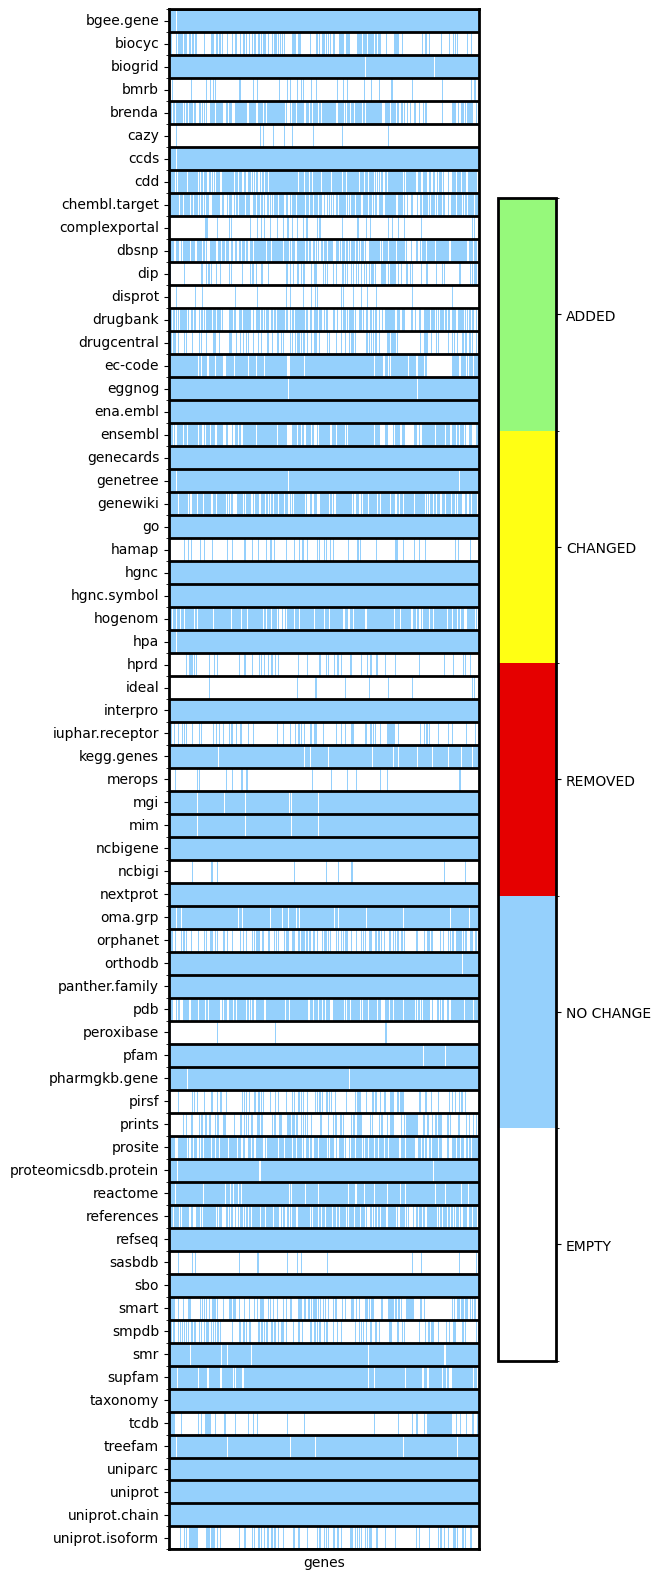

In [9]:
annotation_type = "genes"
all_annotation_keys = set()
for annotation in getattr(model, annotation_type).list_attr("annotation"):
    all_annotation_keys.update(list(annotation.keys()))
# Get annotation df is agnostic to object type, swap ID column with the `annotation_type`
df_annotations = get_annotation_df(
    getattr(model, annotation_type), sorted(list(all_annotation_keys))
).rename({"id": annotation_type}, axis=1)

if compare:
    try:
        df_previous = pd.read_csv(
            f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv",
            sep="\t",
            index_col=0,
            dtype=str,
        )
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=[annotation_type], dtype=str)

    fig, ax = plt.subplots(1, 1, figsize=(5, 20))
    df_comparision = compare_tables(
        df_previous.set_index(annotation_type),
        df_annotations.set_index(annotation_type),
    )
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = (
            df_annotations[col]
            .apply(lambda x: split_string(x))
            .explode(col)
            .drop_duplicates()
        )
        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_annotations.to_csv(f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv", sep="\t")
else:
    df_annotations.to_csv(f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}.tsv", sep="\t")
df_annotations